#Clustering Analysis of Breast Cancer Gene Expression Data

## 1. Introduction
The objective of this project is to apply unsupervised learning techniques such as clustering to explore subgroup classifications of breast cancer based on gene expression similarities.
<!-- By leveraging clustering methods, we aim to identify patterns that may reveal biologically relevant insights, which can contribute to diagnosis, treatment, personalized medicine. -->
The dataset consists of 151 samples with gene expression
profiles of 54,676 genes, categorized into six distinct classes of breast cancer.

1. Data Preprocessing

In [1]:
!pip install kagglehub

In [30]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import kagglehub
from kagglehub import KaggleDatasetAdapter
file_path = "Breast_GSE45827.csv"
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "brunogrisci/breast-cancer-gene-expression-cumida",
  file_path
)

<ipython-input-30-90deef77fa5f>:6: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


In [33]:
df=df.set_index("samples")

In [35]:
missing_values_per_column = df.isnull().sum()
total_missing_values = df.isnull().sum().sum()

print("Number of missing values in each attribute:")
print(missing_values_per_column)

print("\n Total number of missing values in the file:", total_missing_values)

Number of missing values in each attribute:
type               0
1007_s_at          0
1053_at            0
117_at             0
121_at             0
                  ..
AFFX-ThrX-5_at     0
AFFX-ThrX-M_at     0
AFFX-TrpnX-3_at    0
AFFX-TrpnX-5_at    0
AFFX-TrpnX-M_at    0
Length: 54676, dtype: int64

 Total number of missing values in the file: 0


In [36]:
duplicates = df[df.duplicated()]
print(f"Number of duplicate rows: {duplicates.shape[0]}")

Number of duplicate rows: 0


In [37]:
num_cols = df.select_dtypes(include=['number']).columns
for col in num_cols:
    if (df[col] < 0).any():
        print(f"Column '{col}' contains negative values.")

Encoding Cancer Type

In [38]:
from sklearn.preprocessing import OrdinalEncoder
column = "type"

# Initialize and fit the encoder
encoder = OrdinalEncoder()
df[[column]] = encoder.fit_transform(df[[column]])

df[column] = df[column].astype(int)
labels=df["type"]
encoded_file_path = "Breast_GSE45827_encoded.csv"
df.to_csv(encoded_file_path, index=True)
df.head()

,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
samples,,,,,,,,,,,,,,,,,,,,,
84,1,9.850040,8.097927,6.424728,7.353027,3.029122,6.880079,4.963740,4.408328,8.870780,...,12.229711,11.852955,13.658701,13.477698,6.265781,5.016196,4.901594,2.966657,3.508495,3.301999
85,1,9.861357,8.212222,7.062593,7.685578,3.149468,7.542283,5.129607,4.584418,7.767646,...,12.178531,11.809408,13.750086,13.470146,6.771853,5.291005,5.405839,2.934763,3.687666,3.064299
87,1,10.103478,8.936137,5.735970,7.687822,3.125931,6.562369,4.813449,4.425195,9.417956,...,12.125108,11.725766,13.621732,13.295080,6.346952,5.171403,5.184286,2.847684,3.550597,3.158535
90,1,9.756875,7.357148,6.479183,6.986624,3.181638,7.802344,5.490982,4.567956,9.022345,...,12.111235,11.719215,13.743108,13.508861,6.610284,5.193356,5.086569,3.031602,3.524981,3.272665
91,1,9.408330,7.746404,6.693980,7.333426,3.169923,7.610457,5.372469,4.424426,9.400056,...,12.173642,11.861296,13.797774,13.542206,6.414354,5.040202,5.235318,2.956232,3.445501,3.193947


In [39]:
encoding_map = {i: category for i, category in enumerate(encoder.categories_[0])}
print("Encoding Mapping:", encoding_map)

Encoding Mapping: {0: 'HER', 1: 'basal', 2: 'cell_line', 3: 'luminal_A', 4: 'luminal_B', 5: 'normal'}


##Feature Selection and Dimension Reduction

Identification of most relevant genes contributing to breast cancer classification using ANOVA F-TEST

In [40]:
from sklearn.feature_selection import SelectKBest, f_classif

# X=pd.DataFrame(X_s, columns=df.columns, index=df.index)
skb = SelectKBest(f_classif, k=10)
X_sel = skb.fit_transform(df[df.columns[1:]], labels)
mask = skb.get_support()
selected_features = df.columns[1:][mask]
print(selected_features)

Index(['200795_at', '202878_s_at', '205225_at', '210052_s_at', '210809_s_at',
       '216836_s_at', '222358_x_at', '222608_s_at', '232814_x_at',
       '240205_x_at'],
      dtype='object')


The problem statement stated that we needed to identify the most relevant genes contributing to breast cancer classification.The top 10 discriminative genes are the ones mentioned above.This analysis was not used for clustering analysis as labels were used to determine these genes

Low variance genes contribute little to the analysis

In [41]:
expr=df
labels=df["type"]
expr=expr.iloc[:,1:]
expr=expr.T
var = expr.var(axis=1)
expr_filt = expr.loc[var > var.quantile(0.5)]
print(f"Kept {expr_filt.shape[0]} high‑variance genes")

Kept 27337 high‑variance genes


In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(expr_filt.T)

In [43]:
X_scaled.shape

(151, 27337)

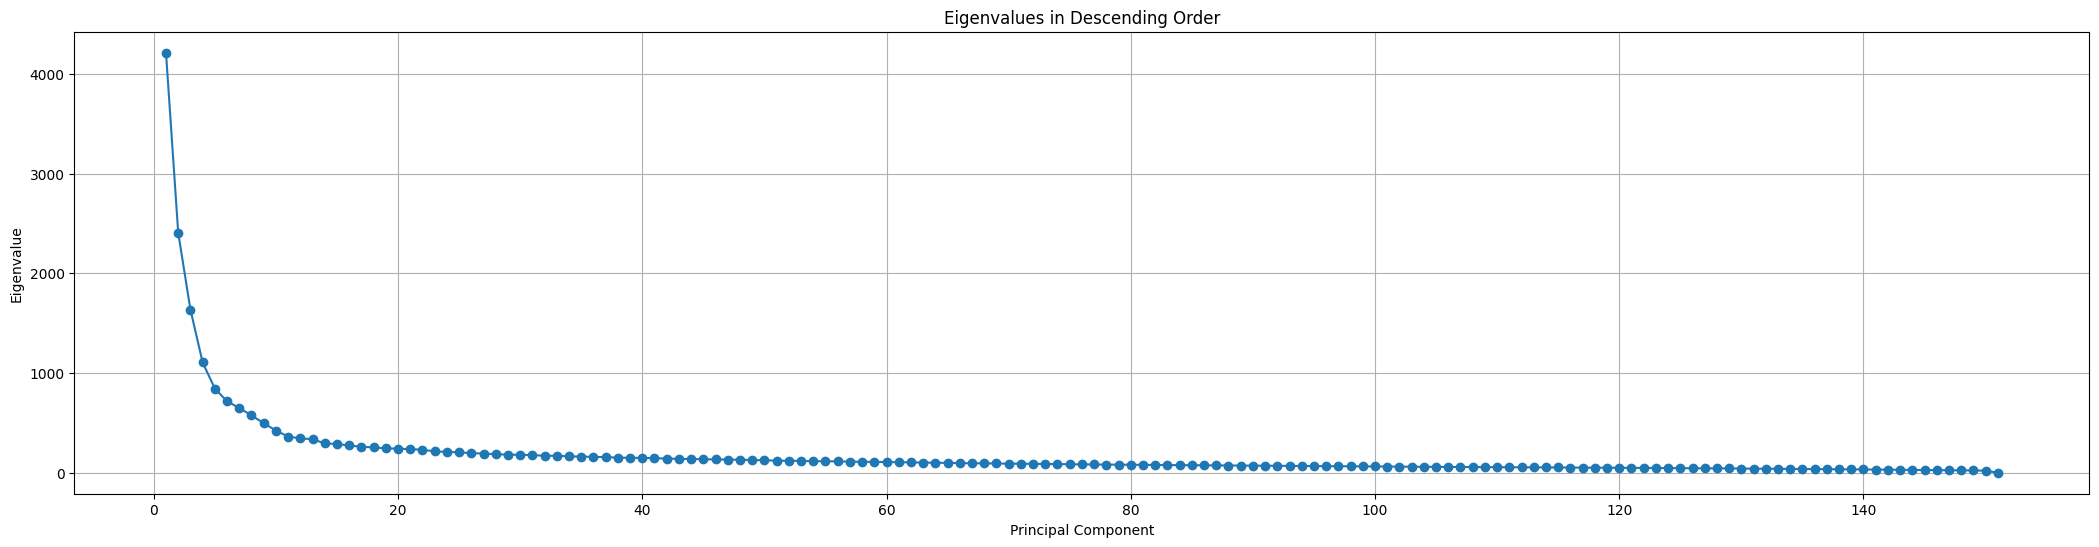

In [44]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA()
pca1 = pca.fit_transform(X_scaled)

eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

plt.figure(figsize=(26, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.title('Eigenvalues in Descending Order')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

In [45]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA().fit(X_scaled)
cumulative_variance = pca.explained_variance_ratio_.cumsum()  # Cumulative sum of explained variance
num_components = np.argmax(cumulative_variance >= 0.95) + 1  # First index where variance reaches 95%
print(f"Optimal number of components: {num_components}")

Optimal number of components: 115


115 features too high for 151 samples

In [46]:
num_components = np.argmax(cumulative_variance >= 0.85) + 1  # First index where variance reaches 85%
print(f"Optimal number of components: {num_components}")

Optimal number of components: 74


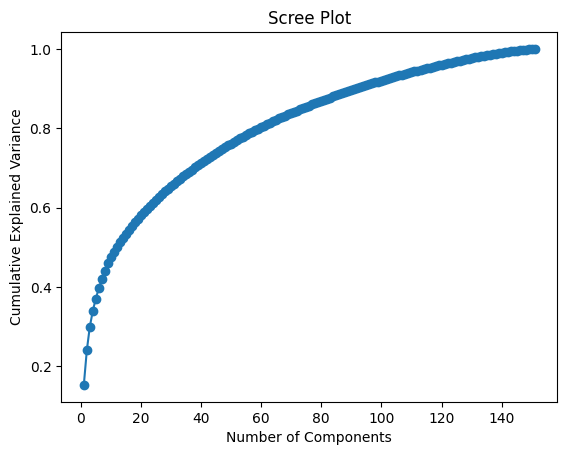

In [47]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot")
plt.show()

In [48]:
from sklearn.decomposition import PCA


pca = PCA(n_components=74, svd_solver="full", random_state=0)
X_pca_full = pca.fit_transform(X_scaled)
print(f"PCA retained {X_pca_full.shape[1]} components")

# For 3D plotting:
X_pca3 = X_pca_full[:, :3]

PCA retained 74 components


In [49]:
import plotly.express as px
df1 = pd.DataFrame(X_pca3, columns=["PC1","PC2","PC3"])
df1["cluster"] = labels.reset_index(drop=True)
fig = px.scatter_3d(df1, x="PC1", y="PC2", z="PC3",
                    color="cluster", opacity=0.8,
                    title="Original Clusters on PCA Space")
fig.show()

In [50]:
import umap
X_umap = umap.UMAP(n_components=5, random_state=0).fit_transform(X_pca_full)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [51]:
X_umap.shape

(151, 5)

#Model Training

##Kmeans For k=6

In [52]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

In [53]:
kmeans = KMeans(n_clusters=6,random_state=42).fit(X_umap)
km_labels1 = kmeans.labels_
df2 = pd.DataFrame(X_pca3, columns=["PC1","PC2","PC3"])
df2["cluster"] = km_labels1
fig = px.scatter_3d(df2, x="PC1", y="PC2", z="PC3",
                    color="cluster", opacity=0.7,
                    title="Kmeans Clusters(k=6) on PCA Space")
fig.show()

In [54]:
from sklearn.metrics import silhouette_score

best_k = None
best_score = -1
for k in range(3, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    y_kmeans = kmeans.fit_predict(X_umap)
    score = silhouette_score(X_umap, y_kmeans)
    print(f"K={k}, Silhouette Score: {score:.4f}")

    if score > best_score:
        best_score = score
        best_k = k

print(f"Best K: {best_k} with Silhouette Score: {best_score:.4f}")

K=3, Silhouette Score: 0.6288
K=4, Silhouette Score: 0.5021
K=5, Silhouette Score: 0.3855
K=6, Silhouette Score: 0.5565
K=7, Silhouette Score: 0.4910
K=8, Silhouette Score: 0.4677
Best K: 3 with Silhouette Score: 0.6288


##For optimal K determined using Silhouette score

In [55]:
kmeans = KMeans(n_clusters=3,random_state=42).fit(X_umap)
km_labels2 = kmeans.labels_
df2 = pd.DataFrame(X_pca3, columns=["PC1","PC2","PC3"])
df2["cluster"] = km_labels2
fig = px.scatter_3d(df2, x="PC1", y="PC2", z="PC3",
                    color="cluster", opacity=0.7,
                    title="Kmeans Clusters(k=3) on PCA Space")
fig.show()

#Kmeans With Mahalanobis Distance

In [56]:
from scipy.spatial.distance import mahalanobis
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Mahalanobis KMeans Function
def kmeans_mahalanobis(X, k, max_iters=100):
    centroids = X[np.random.choice(len(X), k, replace=False)]
    VI = np.linalg.inv(np.cov(X.T))

    for _ in range(max_iters):
        labels = np.array([
            np.argmin([mahalanobis(x, centroid, VI) for centroid in centroids])
            for x in X
        ])
        new_centroids = np.array([
            X[labels == j].mean(axis=0) if np.any(labels == j) else centroids[j]
            for j in range(k)
        ])
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids

    return labels, centroids



##For k=6

In [57]:
labels_maha1, centroids_maha = kmeans_mahalanobis(X_umap, 6)
df1 = pd.DataFrame(X_pca3, columns=["PC1","PC2","PC3"])
df1["cluster"] = labels_maha1
fig = px.scatter_3d(df1, x="PC1", y="PC2", z="PC3",
                    color="cluster", opacity=0.7,
                    title="Kmeans Clusters(k=6) with mahalnobis distance on PCA Space")
fig.show()

Optimal K keeps changing due to random initialization of centroids

In [90]:
best_k = None
best_score = -1
for k in range(3, 9):
    y_kmeans_maha,_ = kmeans_mahalanobis(X_umap,k)
    score = silhouette_score(X_umap, y_kmeans_maha)
    print(f"K={k}, Silhouette Score: {score:.4f}")

    if score > best_score:
        best_score = score
        best_k = k
        labels_maha2 = y_kmeans_maha

print(f"Best K: {best_k} with Silhouette Score: {best_score:.4f}")



K=3, Silhouette Score: 0.0782
K=4, Silhouette Score: 0.2496
K=5, Silhouette Score: 0.1682
K=6, Silhouette Score: 0.2488
K=7, Silhouette Score: 0.2012
K=8, Silhouette Score: 0.2265
Best K: 4 with Silhouette Score: 0.2496


##For optimal K determined using Silhouette score

In [91]:
df1 = pd.DataFrame(X_pca3, columns=["PC1","PC2","PC3"])
df1["cluster"] = labels_maha2
fig = px.scatter_3d(df1, x="PC1", y="PC2", z="PC3",
                    color="cluster", opacity=0.7,
                    title="Kmeans Clusters(k=4) with mahalnobis distance on PCA Space")
fig.show()

##GMM for K=6

In [92]:
gmm = GaussianMixture(n_components=6, random_state=42).fit(X_umap)
gmm_labels1 = gmm.predict(X_umap)
df1 = pd.DataFrame(X_pca3, columns=["PC1","PC2","PC3"])
df1["cluster"] = gmm_labels1
fig = px.scatter_3d(df1, x="PC1", y="PC2", z="PC3",
                    color="cluster", opacity=0.7,
                    title="GMM Clusters(k=6) on PCA Space")
fig.show()

##For Optimal K determined using silhouette score

In [93]:
best_k = None
best_score = -1
for k in range(3, 9):
    gmm = GaussianMixture(n_components=k, random_state=42)
    y_gmm = gmm.fit_predict(X_umap)
    score = silhouette_score(X_umap, y_gmm)
    print(f"K={k}, Silhouette Score: {score:.4f}")

    if score > best_score:
        best_score = score
        best_k = k

print(f"Best K: {best_k} with Silhouette Score: {best_score:.4f}")

K=3, Silhouette Score: 0.6288
K=4, Silhouette Score: 0.4910
K=5, Silhouette Score: 0.4163
K=6, Silhouette Score: 0.5291
K=7, Silhouette Score: 0.4456
K=8, Silhouette Score: 0.4298
Best K: 3 with Silhouette Score: 0.6288


##For optimal K determined using Silhouette score

In [94]:
gmm = GaussianMixture(n_components=3, random_state=42).fit(X_umap)
gmm_labels2 = gmm.predict(X_umap)
df1 = pd.DataFrame(X_pca3, columns=["PC1","PC2","PC3"])
df1["cluster"] = gmm_labels2
fig = px.scatter_3d(df1, x="PC1", y="PC2", z="PC3",
                    color="cluster", opacity=0.7,
                    title="GMM Clusters(k=3) on PCA Space")
fig.show()

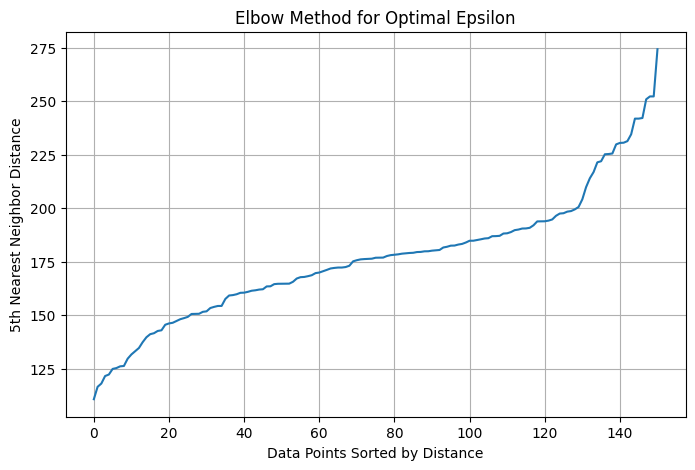

In [95]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Find the optimal eps value using K-distance plot
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort and plot the distances (Elbow method)
distances = np.sort(distances[:, 4])
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Data Points Sorted by Distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("Elbow Method for Optimal Epsilon")
plt.grid(True)
plt.show()

In [96]:
from sklearn.cluster import DBSCAN

optimal_eps = 200
min_samples = 5

# Train DBSCAN
dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples)
y_dbscan1 = dbscan.fit_predict(X_scaled)

# Count clusters
num_clusters = len(set(y_dbscan1)) - (1 if -1 in y_dbscan1 else 0)
print(f"DBSCAN found {num_clusters} clusters")

# Evaluate only if DBSCAN found clusters
if num_clusters <= 1:
    print("DBSCAN did not find valid clusters.")

DBSCAN found 1 clusters
DBSCAN did not find valid clusters.


DBSCAN is not able to find any valid clusters

In [97]:
df1 = pd.DataFrame(X_pca3, columns=["PC1","PC2","PC3"])
df1["cluster"] = y_dbscan1
fig = px.scatter_3d(df1, x="PC1", y="PC2", z="PC3",
                    color="cluster", opacity=0.7,
                    title="DBSCAN Clusters on PCA Space")
fig.show()

##Agglomerarive Clustering for k=6 using Cosine Distance

In [98]:
from sklearn.metrics.pairwise import cosine_distances

#Cosine distance (better for high‑dimensional gene data)
D = cosine_distances(X_umap)

In [99]:
from sklearn.cluster import AgglomerativeClustering
agglo = AgglomerativeClustering(n_clusters=6,metric='precomputed',linkage='average').fit(D)
agglo_labels1 = agglo.labels_
df1 = pd.DataFrame(X_pca3, columns=["PC1","PC2","PC3"])
df1["cluster"] = agglo_labels1
fig = px.scatter_3d(df1, x="PC1", y="PC2", z="PC3",
                    color="cluster", opacity=0.7,
                    title="AGNES Clusters(k=6) on PCA Space")
fig.show()

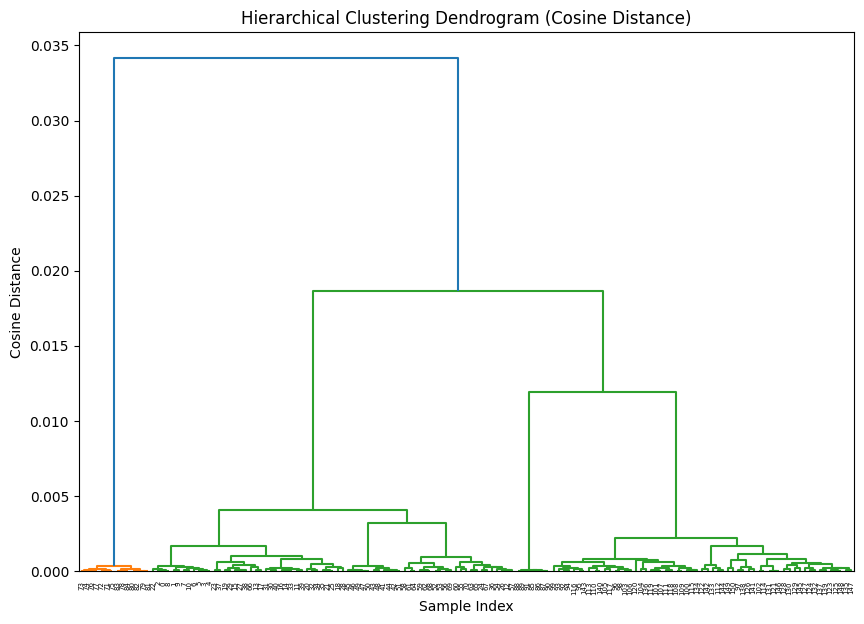

In [100]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
condensed_dist_matrix = squareform(D)
linkage_matrix = linkage(condensed_dist_matrix, method='average')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram (Cosine Distance)')
plt.xlabel('Sample Index')
plt.ylabel('Cosine Distance')
plt.show()

In [101]:
best_k = None
best_score = -1
for k in range(3, 9):
    agglo = AgglomerativeClustering(n_clusters=k)
    y_agglo = agglo.fit_predict(X_umap)
    score = silhouette_score(D, y_agglo,metric="precomputed")
    print(f"K={k}, Silhouette Score: {score:.4f}")

    if score > best_score:
        best_score = score
        best_k = k

print(f"Best K: {best_k} with Silhouette Score: {best_score:.4f}")

K=3, Silhouette Score: 0.8210
K=4, Silhouette Score: 0.8330
K=5, Silhouette Score: 0.7360
K=6, Silhouette Score: 0.7534
K=7, Silhouette Score: 0.6539
K=8, Silhouette Score: 0.6326
Best K: 4 with Silhouette Score: 0.8330


##For optimal number of clusters determined by Silhouette score

In [102]:
agglo = AgglomerativeClustering(n_clusters=4,metric='precomputed',linkage='average').fit(D)
agglo_labels2 = agglo.labels_
df1 = pd.DataFrame(X_pca3, columns=["PC1","PC2","PC3"])
df1["cluster"] = agglo_labels2
fig = px.scatter_3d(df1, x="PC1", y="PC2", z="PC3",
                    color="cluster", opacity=0.7,
                    title="AGNES Clusters(k=4) on PCA Space")
fig.show()

##Fuzzy CMEANS for k=6

In [103]:
!pip install scikit-fuzzy

In [104]:
import numpy as np
import skfuzzy as fuzz


data = X_umap.T

n_clusters = 6
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data, c=n_clusters, m=2.0, error=0.005, maxiter=1000, init=None, seed=0
)

fcm_labels1 = np.argmax(u, axis=0)
df1 = pd.DataFrame(X_pca3, columns=["PC1","PC2","PC3"])
df1["cluster"] = fcm_labels1
fig = px.scatter_3d(df1, x="PC1", y="PC2", z="PC3",
                    color="cluster", opacity=0.7,
                    title="FCMEANS Clusters(k=6) on PCA Space")
fig.show()

In [105]:
best_k = None
best_score = -1
for k in range(3, 9):
    n_clusters = k
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data, c=n_clusters, m=2.0, error=0.005, maxiter=1000, init=None, seed=0
)

    fcm_labels = np.argmax(u, axis=0)
    score = silhouette_score(X_umap, fcm_labels)
    print(f"K={k}, Silhouette Score: {score:.4f}")

    if score > best_score:
        best_score = score
        best_k = k

print(f"Best K: {best_k} with Silhouette Score: {best_score:.4f}")

K=3, Silhouette Score: 0.6288
K=4, Silhouette Score: 0.2468
K=5, Silhouette Score: 0.3892
K=6, Silhouette Score: 0.4699
K=7, Silhouette Score: 0.4901
K=8, Silhouette Score: 0.4677
Best K: 3 with Silhouette Score: 0.6288


##For optimal number of clusters determined by Silhouette score

In [106]:
n_clusters = 3
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data, c=n_clusters, m=2.0, error=0.005, maxiter=1000, init=None, seed=0
)

fcm_labels2 = np.argmax(u, axis=0)
df1 = pd.DataFrame(X_pca3, columns=["PC1","PC2","PC3"])
df1["cluster"] = fcm_labels2
fig = px.scatter_3d(df1, x="PC1", y="PC2", z="PC3",
                    color="cluster", opacity=0.7,
                    title="FCMEANS Clusters(k=3) on PCA Space")
fig.show()

##Metrics

##For k=6

In [107]:
labels=df["type"]

In [108]:
from sklearn.metrics import adjusted_rand_score, silhouette_score
import numpy as np

def purity_score(y_true, y_pred):
    contingency = pd.crosstab(y_true, y_pred)
    return np.sum(np.max(contingency.values, axis=0)) / np.sum(contingency.values)

methods = {
    "KMeans": km_labels1,
    "Mahalanobis": labels_maha1,
    "GMM": gmm_labels1,
    "DBSCAN": y_dbscan1,
    "FCM": fcm_labels1,
}

results = []
for name, pred in methods.items():
    sil = silhouette_score(X_umap, pred)
    ari = adjusted_rand_score(labels, pred)
    pur = purity_score(labels, pred)
    results.append((name, ari, sil, pur))
sil_agglo=silhouette_score(D, agglo_labels1,metric="precomputed")
ari_agglo=adjusted_rand_score(labels, agglo_labels1)
pur_agglo=purity_score(labels, agglo_labels1)
results.append(("Agglomerative", ari_agglo, sil_agglo, pur_agglo))
results_df = pd.DataFrame(results, columns=["Method","ARI","Silhouette","Purity"])
print(results_df)

          Method       ARI  Silhouette    Purity
0         KMeans  0.634185    0.556483  0.761589
1    Mahalanobis  0.327955    0.234030  0.602649
2            GMM  0.560792    0.529128  0.721854
3         DBSCAN  0.080284    0.380258  0.331126
4            FCM  0.817347    0.469938  0.927152
5  Agglomerative  0.654901    0.753373  0.774834


##For optimal k

In [109]:
methods = {
    "KMeans": km_labels2,
    "Mahalanobis": labels_maha2,
    "GMM": gmm_labels2,
    "DBSCAN": y_dbscan1,
    "FCM": fcm_labels2,
}

results = []
for name, pred in methods.items():
    sil = silhouette_score(X_umap, pred)
    ari = adjusted_rand_score(labels, pred)
    pur = purity_score(labels, pred)
    results.append((name, ari, sil, pur))
sil_agglo=silhouette_score(D, agglo_labels2,metric="precomputed")
ari_agglo=adjusted_rand_score(labels, agglo_labels2)
pur_agglo=purity_score(labels, agglo_labels2)
results.append(("Agglomerative", ari_agglo, sil_agglo, pur_agglo))
results_df = pd.DataFrame(results, columns=["Method","ARI","Silhouette","Purity"])
print(results_df)

          Method       ARI  Silhouette    Purity
0         KMeans  0.506105    0.628781  0.562914
1    Mahalanobis  0.294149    0.249554  0.543046
2            GMM  0.506105    0.628781  0.562914
3         DBSCAN  0.080284    0.380258  0.331126
4            FCM  0.506105    0.628781  0.562914
5  Agglomerative  0.565772    0.833015  0.609272


#Determinig Potential Biomarkers within each cluster

In [110]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

biomarkers = {}
for k in np.unique(labels):
    idx_in  = labels == k
    idx_out = ~idx_in

    # Perform t‐tests across genes:
    # expr_filt is genes × samples, so transpose to samples × genes
    data_in  = expr_filt.T[idx_in]
    data_out = expr_filt.T[idx_out]

    # ttest_ind returns (tstats, pvalues)
    tstats, pvals = ttest_ind(data_in, data_out, axis=0, equal_var=False)

    # Select genes with p < 0.01
    sig_idx = np.where(pvals < 0.01)[0]
    # Rank by absolute t‐statistic
    top_idx = sig_idx[np.argsort(-np.abs(tstats[sig_idx]))]
    top_genes = expr_filt.index[top_idx][:5]  # top 5 genes

    biomarkers[k] = list(top_genes)

for k, genes in biomarkers.items():
    print(f"Cluster {k} biomarkers:", genes)


Cluster 0 biomarkers: ['216836_s_at', '210930_s_at', '210761_s_at', '224447_s_at', '234354_x_at']
Cluster 1 biomarkers: ['218211_s_at', '226961_at', '235046_at', '229150_at', '228302_x_at']
Cluster 2 biomarkers: ['202878_s_at', '225353_s_at', '223343_at', '200795_at', '213975_s_at']
Cluster 3 biomarkers: ['204603_at', '212195_at', '236641_at', '205046_at', '219010_at']
Cluster 4 biomarkers: ['228241_at', '205225_at', '232322_x_at', '209173_at', '223103_at']
Cluster 5 biomarkers: ['222981_s_at', '219935_at', '222262_s_at', '240277_at', '215438_x_at']


#Gene Expression Heatmap

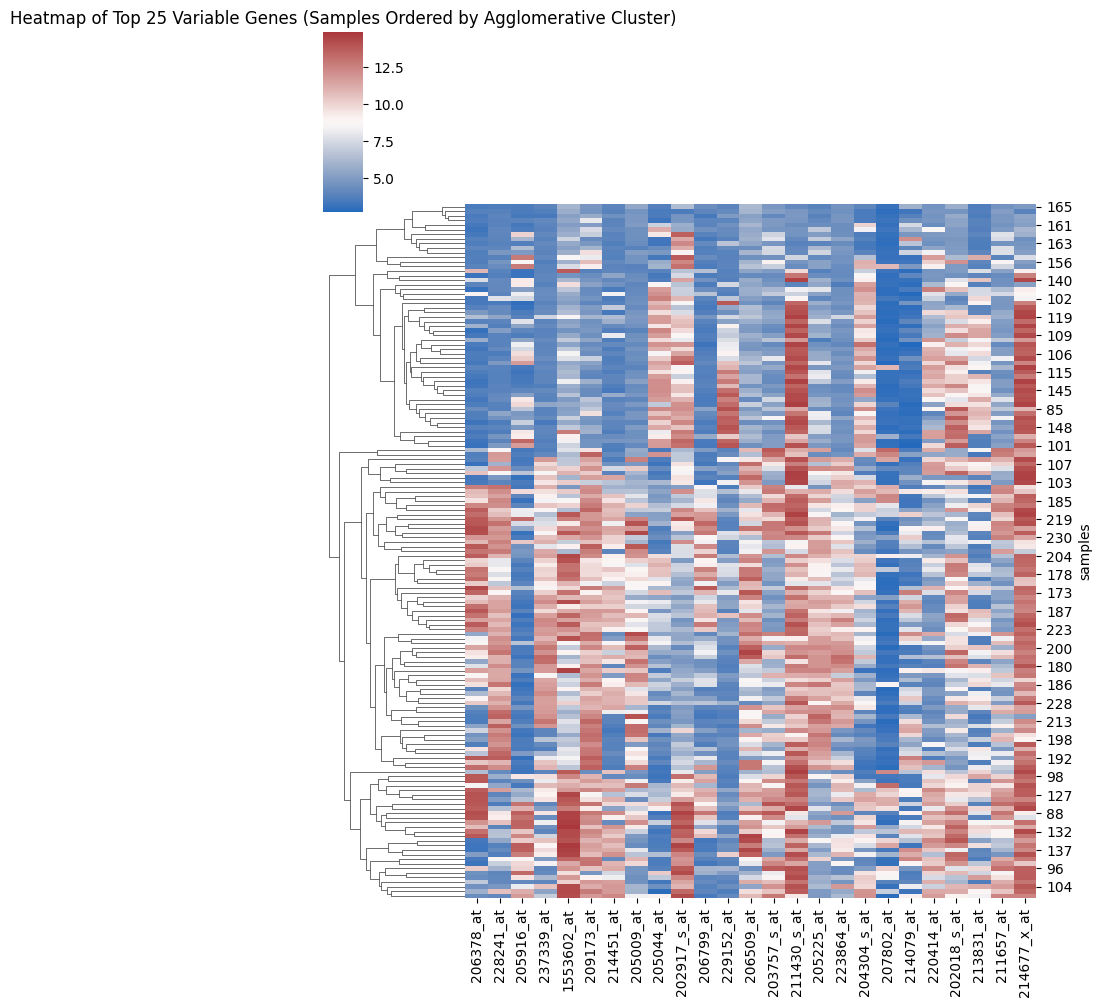

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage


top25= expr_filt.var(axis=1).sort_values(ascending=False).index[:25]
data_hm = expr_filt.loc[top25].T.copy()
data_hm['cluster'] = agglo_labels1
data_hm_sorted = data_hm.sort_values('cluster')
heatmap_data = data_hm_sorted.drop('cluster', axis=1)
row_linkage = linkage(heatmap_data, method='average')


sns.clustermap(
    heatmap_data,
    row_linkage=row_linkage,
    col_cluster=False,
    cmap='vlag',
    figsize=(8, 10)
)
plt.title("Heatmap of Top 25 Variable Genes (Samples Ordered by Agglomerative Cluster)")
plt.show()
